In [1]:
import cv2
import numpy as np

In [2]:
# helper function

def angle_between_3_points(pt1, pt2, pt3):
    """Calculate the angle between three points"""
    
    pt1 = np.array(pt1)
    pt2 = np.array(pt2)
    pt3 = np.array(pt3)
    
    v1 = pt1 - pt2
    v2 = pt3 - pt2
    
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    angle = np.arccos(dot_product / (norm_v1 * norm_v2))
    
    angle_degrees = np.degrees(angle)
    
    return angle_degrees

def calculate_slope(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    return (y2 - y1) / (x2 - x1)

def find_closest_point(p1, p2, contour):
    # convert points to numpy array
    p1 = np.array(p1)
    p2 = np.array(p2)

    # calculate the line parameters
    line_direction = p2 - p1
    line_length = np.linalg.norm(line_direction)
    if line_length == 0:
        return None, None  # points coincide, no line to search
    line_direction = line_direction / line_length
    line_normal = np.array([-line_direction[1], line_direction[0]])

    # initialize minimum distance and closest point
    min_distance = np.inf
    closest_point = None
    closest_point_index = None

    # iterate over all contour points
    for i in range(len(contour)):
        point = contour[i]
        # calculate the distance from the point to the line
        pt_to_p1 = point[0] - p1
        pt_to_p2 = point[0] - p2
        projection = np.dot(pt_to_p1, line_direction) * line_direction
        perpendicular = pt_to_p1 - projection
        distance = np.linalg.norm(perpendicular)
        
        dot_product = np.dot(pt_to_p1, pt_to_p2)
        if dot_product > 0:
            continue

        # if the distance is smaller than the current minimum distance, update the closest point
        if distance < min_distance:
            min_distance = distance
            closest_point = point[0]
            closest_point_index = i
            
    return closest_point, closest_point_index


In [3]:
mask = cv2.imread('created_masks/UCSB-IZC00046621_5x_hef_lg/eyes.png'
                  , cv2.IMREAD_GRAYSCALE)
ret, thresh = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

to do: how to determine the order of box

In [4]:
cnt = contours[0]
canvas = np.zeros_like(mask)
canvas.fill(255)
canvas = cv2.cvtColor(canvas, cv2.COLOR_GRAY2BGR)
cv2.drawContours(canvas, cnt, -1, (0, 255, 0), 5)

# find the bounding box of the contour 
rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
box = np.int0(box)
#left_box_center = ((box[0][0] + box[1][0])//2, (box[0][1] + box[1][1])//2)

cv2.drawContours(canvas,[box],0,(0,255,),5)

M = cv2.moments(cnt)
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])
centroid_point = (cx,cy)
cv2.circle(canvas, (cx, cy), radius=20, color=(0, 0, 255), thickness=-1)

point1, index1= find_closest_point(centroid_point, tuple(box[2]), cnt)
point2, index2 = find_closest_point(centroid_point, tuple(box[3]), cnt)

direction = "right"
if direction == "right":
    cv2.line(canvas, centroid_point, tuple(box[2]), color=(255, 255, 0), thickness=2, lineType=cv2.LINE_AA, shift=0)
    cv2.line(canvas, centroid_point, tuple(box[3]), color=(255, 255, 0), thickness=2, lineType=cv2.LINE_AA, shift=0)
    cv2.circle(canvas, tuple(point1), 20, (255, 0, 0), -1)
    cv2.circle(canvas, tuple(point2), 20, (255, 0, 0), -1)
    print(angle_between_3_points(box[2], centroid_point, box[3]))

line_contour = np.array([centroid_point, tuple(box[2])]).reshape((-1, 1, 2)).astype(np.int32)

cv2.namedWindow("binary", cv2.WINDOW_NORMAL)
cv2.imshow('binary', canvas)
cv2.waitKey(0)
cv2.destroyAllWindows()

133.44641634986323


In [369]:
## segment the contour 
index = np.sort([index1, index2])
segments = np.split(cnt, index)[1]

In [370]:
canvas = np.zeros_like(mask)
canvas.fill(255)
canvas = cv2.cvtColor(canvas, cv2.COLOR_GRAY2BGR)
cv2.drawContours(canvas, segments, -1, (0, 255, 0), 5)

cv2.namedWindow("binary", cv2.WINDOW_NORMAL)
cv2.imshow('binary', canvas)
cv2.waitKey(0)
cv2.destroyAllWindows()


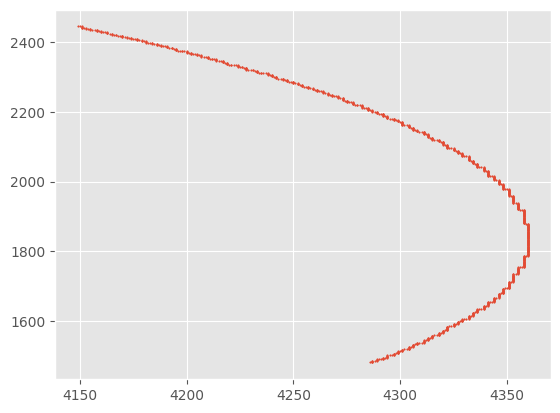

In [374]:
# project contours into R^2 
import matplotlib.pyplot as plt
from scipy.spatial import distance

coords = segments.reshape((len(segments), 2))
x_values = [coord[0] for coord in coords]
y_values = [coord[1] for coord in coords]


plt.scatter(x_values, y_values, s=1)
plt.show()


In [373]:
# distance between adjacent points in the contour
distances = [distance.euclidean(coords[i], coords[i+1]) for i in range(len(coords)-1)]
print(list(set(distances)))
coords.shape

[1.0, 1.4142135623730951]


(1128, 2)

In [167]:
# import math

# def find_point_on_line(points, total_distance, start_point, start_index):
#     accumulated_distance = 0
#     current_point = start_point
    
#     for i in range(start_index+1, len(points)):
#         distance = math.sqrt((start_point[0] - current_point[0])**2 + (start_point[1] - current_point[1])**2)
#         if distance >= total_distance:
#             update_index = i
#             remaining_distance = total_distance - accumulated_distance
#             proportion = remaining_distance / distance
#             x = current_point[0] + (points[i][0] - current_point[0]) * proportion
#             y = current_point[1] + (points[i][1] - current_point[1]) * proportion
#             #print(accumulated_distance)
#             return update_index, [x, y]
#         else:
#             accumulated_distance += distance
#             current_point = points[i]
    
#     # If we reach the end of the array, return the last point
#     return points[-1]


In [375]:
import math

def find_point_on_line(points, total_distance, start_point, start_index):
    accumulated_distance = 0
    current_point = start_point
    
    
    for i in range(start_index+1, len(points)):
        distance = math.sqrt((points[i][0] - current_point[0])**2 + (points[i][1] - current_point[1])**2)
        if accumulated_distance + distance >= total_distance:
            update_index = i
            remaining_distance = total_distance - accumulated_distance
            proportion = remaining_distance / distance
            x = current_point[0] + (points[i][0] - current_point[0]) * proportion
            y = current_point[1] + (points[i][1] - current_point[1]) * proportion
            #print(accumulated_distance)
            return update_index, [x, y]
        else:
            accumulated_distance += distance
            current_point = points[i]
    
    # If we reach the end of the array, return the last point
    return points[-1]


In [409]:
import random
# sample size 
num_omma = 8
omma_diameter_pixel = 25
# make sure no out of range
upper_bound = int(np.ceil(omma_diameter_pixel*num_omma))
new_coords = coords[:-abs(upper_bound)]
start = random.choice(new_coords)

In [410]:
omma_diameter_pixel

25

In [411]:
# problem with updating current_index
omma_points = []
current_omma = start
new_coords_omma = coords.copy()
current_index = np.where((new_coords_omma == current_omma).all(axis=1))[0][0]

i = 0 
while i < num_omma:
    i += 1
    current_index, next_omma = find_point_on_line(new_coords_omma, omma_diameter_pixel, current_omma, current_index)
    #print(current_index)
    new_coords_omma = np.insert(new_coords_omma, current_index - 1, next_omma, axis = 0)
    omma_points.append(next_omma)
    current_omma = next_omma
    

In [412]:
# coordninates of sampled ommatidia
omma_points

[[4320.828427124746, 2105.171572875254],
 [4327.0, 2085.0710678118658],
 [4332.0, 2063.899494936612],
 [4336.192388155425, 2041.8076118445751],
 [4341.0, 2020.5563491861044],
 [4346.0, 1999.3847763108506],
 [4350.786796564404, 1978.0],
 [4353.0, 1954.6274169979695]]

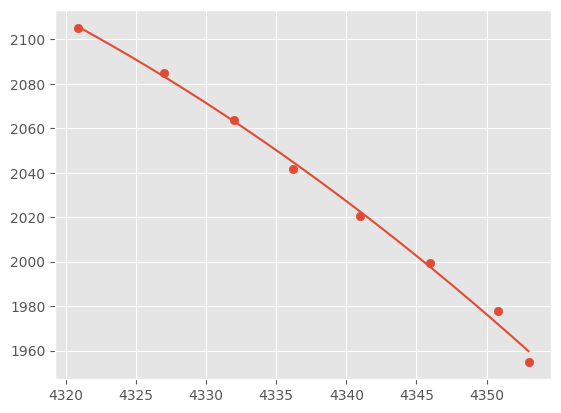

In [413]:
# fit the sampled points to a polynomial regression
from scipy.optimize import curve_fit


x = np.array([p[0] for p in omma_points])
y = np.array([p[1] for p in omma_points])

coeffs = np.polyfit(x, y, 2)
curve = np.poly1d(coeffs)
# plot the closed curve 
xp = np.linspace(x[0], x[-1], 1000)
plt.plot(xp, curve(xp))
plt.scatter(x,y)
plt.show()

### Sampling Radius of Curvature(estimated by circle fitting)

In [173]:
def ls_circle(xx,yy):
   asize = np.size(xx)
   #print('Circle input size is ' + str(asize))
   J=np.zeros((asize,3))
   ABC=np.zeros(asize)
   K=np.zeros(asize)

   for ix in range(0,asize):
      x=xx[ix]
      y=yy[ix]

      J[ix,0]=x*x + y*y;
      J[ix,1]=x;
      J[ix,2]=y;
      K[ix]=1.0

   K=K.transpose()
   JT=J.transpose()
   JTJ = np.dot(JT,J)
   InvJTJ=np.linalg.inv(JTJ);

   ABC= np.dot(InvJTJ, np.dot(JT,K))
   #If A is negative, R will be negative
   A=ABC[0]
   B=ABC[1]
   C=ABC[2]

   xofs=-B/(2*A)
   yofs=-C/(2*A)
   R=np.sqrt(4*A + B*B + C*C)/(2*A)
   if R < 0.0: R = -R
   return (xofs,yofs,R)

In [420]:
# parameters can be tuned:
# num_omma(5): number of sampling ommatidia; choose smaller number if the eye is small
# number of iteration(10000): sample size  
# omma_diameter_pixel: ommatidia diameter measured in pixels 
# threshold of sse(10): lower threshold means the polynomial regression(k=2)
#                   can capture the poistion of ommatidia more correctly

from tqdm import tqdm
radius_curvature_list = []
radius_list = []

for i in tqdm(range(10000)):
    num_omma = 12
    omma_diameter_pixel = 21
    upper_bound = int(np.ceil(omma_diameter_pixel*num_omma))
    new_coords = coords[:-abs(upper_bound)]
    start = random.choice(new_coords)

    omma_points = []
    current_omma = start
    new_coords_omma = coords.copy()
    current_index = np.where((new_coords_omma == current_omma).all(axis=1))[0][0]

    i = 0 
    while i < num_omma:
        i += 1
        current_index, next_omma = find_point_on_line(new_coords_omma, omma_diameter_pixel, current_omma, current_index)
        #print(current_index)
        new_coords_omma = np.insert(new_coords_omma, current_index - 1, next_omma, axis = 0)
        omma_points.append(next_omma)
        current_omma = next_omma
    
    x = np.array([p[0] for p in omma_points])
    xp = np.linspace(x[0], x[-1], 10)
    y = np.array([p[1] for p in omma_points])

    coeffs = np.polyfit(x, y, 2)
    y_fit = np.polyval(coeffs, x)
    sse = np.sum((y_fit - y)**2)

    if sse > 10:
        continue 
    else:
        poly_curve = np.poly1d(coeffs)
        circle_fit = ls_circle(xp,poly_curve(xp))
        radius_list.append(circle_fit[2]) 
        # deriv1 = poly_curve.deriv()
        # deriv2 = deriv1.deriv()
        # radius = ((1 + deriv1(xp)**2)**1.5) / abs(deriv2(xp))
        # print(radius)
        # radius_curvature_list.append(radius)


100%|██████████| 10000/10000 [00:05<00:00, 1785.25it/s]


In [421]:
# exclude outliers 
if not isinstance(radius_list, np.ndarray):
    radius_list = np.array(radius_list, dtype=float)
threshold = 2  # threshold for Z-score method

mean = np.mean(radius_list)
std = np.std(radius_list)
z_scores = np.abs((radius_list - mean) / std)
filtered_data = radius_list[z_scores < threshold]

In [348]:
from scipy import stats
from scipy.stats import mode

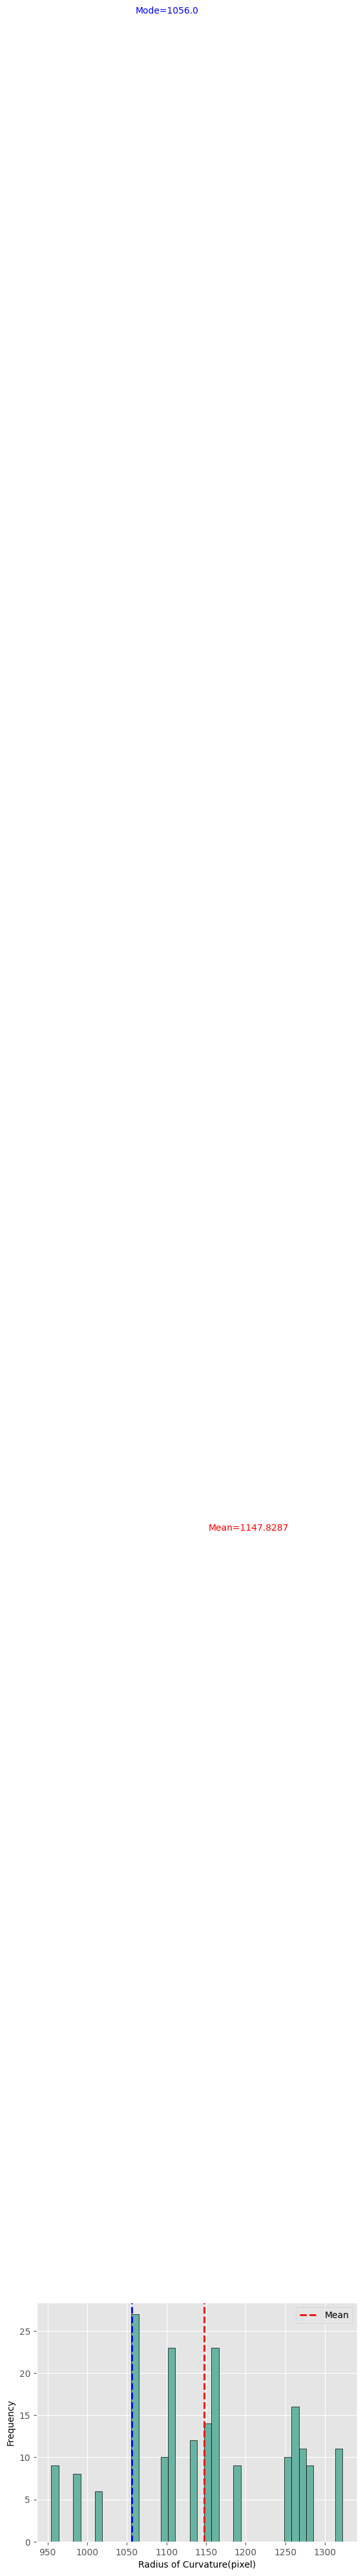

In [422]:
plt.hist(filtered_data,edgecolor='black', color='#69b3a2', bins = 40)
plt.style.use('ggplot')
# plt.figure(figsize=(8,6))
plot_mean = np.mean(filtered_data)
plot_mode = mode(filtered_data.astype(int),keepdims=True)[0][0]
plt.axvline(plot_mean, color='red', linestyle='--', linewidth=2)
plt.axvline(plot_mode, color='blue', linestyle='--', linewidth=2)
plt.text(x=plot_mean+5, y=120, s=f'Mean={plot_mean:.4f}', fontdict=dict(color='red', size=10))
plt.text(x=plot_mode+5, y=300, s=f'Mode={plot_mode:.1f}', fontdict=dict(color='blue', size=10))
plt.legend(['Mean'])
plt.xlabel('Radius of Curvature(pixel)')
plt.ylabel('Frequency')

plt.show()


In [335]:
# confidence interval with larger sample(n>30)
import numpy as np
import scipy.stats as st

st.norm.interval(confidence=0.95, loc=np.mean(filtered_data), scale=st.sem(filtered_data))

(532.4108746154216, 547.1274282112934)

### Sampling Interommatidial Angles

Problems:
1. slow algorithm to find two points with fixed distance on curve(need help)

In [61]:
from scipy.integrate import quad


# def integrand(x):
#     return np.sqrt(1 + dp_dx(x)**2)

def find_x2(arc_length, x1):
    # Integrate the integrand over the interval from x1 to x2 to get the arc length
    x2 = x1
    arc_length_temp = 0.0
    while arc_length_temp < arc_length:
        x2 += 0.0001  # increment x2 by a small amount
        arc_length_temp, _ = quad(integrand, x1, x2)
        #print(arc_length_temp)
    
    return x2

In [113]:
for i in tqdm(range(1000)):
    num_omma = 10
    omma_diameter_pixel = 15.88732
    upper_bound = int(np.ceil(omma_diameter_pixel*num_omma))
    new_coords = coords[:-abs(upper_bound)]
    start = random.choice(new_coords)

    omma_points = []
    current_omma = start
    new_coords_omma = coords.copy()
    current_index = np.where((new_coords_omma == current_omma).all(axis=1))[0][0]

    i = 0 
    while i < num_omma:
        i += 1
        current_index, next_omma = find_point_on_line(new_coords_omma, omma_diameter_pixel, current_omma, current_index)
        new_coords_omma = np.insert(new_coords_omma, current_index - 1, next_omma, axis = 0)
        omma_points.append(next_omma)
        current_omma = next_omma
    
    x = np.array([p[0] for p in omma_points])
    xp = np.linspace(x[0], x[-1], 1000)
    y = np.array([p[1] for p in omma_points])

    coeffs = np.polyfit(x, y, 2)
    y_fit = np.polyval(coeffs, x)
    sse = np.sum((y_fit - y)**2)

    if sse > 10:
        continue 
    else:
        poly_curve = np.poly1d(coeffs)
        deriv1 = poly_curve.deriv()

        def integrand(x):
            return np.sqrt(1 + deriv1(x)**2) 
        
        for i in range(10):
            x_omma1 = np.random.uniform(xp[0],xp[-1])
            y_omma1 = poly_curve(x_omma1)
    
            arc_length = 21.5385
            x_omma2 = find_x2(arc_length, x_omma1)
            if x_omma2 > xp[-1]:
                continue

            y_omma2 = poly_curve(x_omma2)
            d1 = deriv1(x_omma1)
            d2 = deriv1(x_omma2)
            m1 = -1/d1
            b1 = y_omma1 - m1 * x_omma1
            m2 = -1/d2
            b2 = y_omma2 - m2 * x_omma2
            x_intersect = (b2 - b1) / (m1 - m2)
            y_intersect = m1 * x_intersect + b1

            angle = np.arctan(abs((m2 - m1) / (1 + m1 * m2)))
            print(angle)
            angle_list.append(angle)       

  0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\33433\anaconda3\envs\oda\lib\site-packages\IPython\core\interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


0.02534604589959497
0.045990870290028955
0.04478206351692559
0.0384848752840805
0.027015890890874788
0.04544756850479647
0.036294583658673676
0.03474494771522664


  7%|▋         | 71/1000 [02:03<26:59,  1.74s/it]

0.04503698040307043


c:\Users\33433\anaconda3\envs\oda\lib\site-packages\IPython\core\interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


0.01619723112191754
0.017934407023805537
0.023160382516224758
0.02049094082800209
0.01650677581134442
0.023909787054514995
0.02135743718247178
0.023241335421055016


 13%|█▎        | 130/1000 [04:01<27:15,  1.88s/it]

0.02108383464509945


c:\Users\33433\anaconda3\envs\oda\lib\site-packages\IPython\core\interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\33433\anaconda3\envs\oda\lib\site-packages\IPython\core\interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\33433\anaconda3\envs\oda\lib\site-packages\IPython\core\interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


0.025103901511465174
0.022440779495110173
0.018336546470272466
0.02700323504500623
0.019756730665644397
0.02634820636411475


 24%|██▎       | 237/1000 [06:03<18:25,  1.45s/it]

0.019446288305781198


c:\Users\33433\anaconda3\envs\oda\lib\site-packages\IPython\core\interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\33433\anaconda3\envs\oda\lib\site-packages\IPython\core\interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


0.016825800150322725
0.022257401168173582
0.0185453388997145
0.02398866811582355
0.02124042382459511
0.01895770621678986
0.020242353585918502
0.022970317796314844


 28%|██▊       | 280/1000 [08:04<21:29,  1.79s/it]

0.02519152258144434


c:\Users\33433\anaconda3\envs\oda\lib\site-packages\IPython\core\interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\33433\anaconda3\envs\oda\lib\site-packages\IPython\core\interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\33433\anaconda3\envs\oda\lib\site-packages\IPython\core\interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


0.02744368725312617
0.026431559932302184
0.020968421074340427
0.021879702365831918
0.02631149097667576
0.0229403188003502
0.02237463187506537
0.024946328106324512


 33%|███▎      | 328/1000 [10:11<22:48,  2.04s/it]

0.021012742574873115


c:\Users\33433\anaconda3\envs\oda\lib\site-packages\IPython\core\interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\33433\anaconda3\envs\oda\lib\site-packages\IPython\core\interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


0.025670266809010477
0.041176006533984816
0.029855167532493634
0.037188722152255584
0.03385905506091886
0.025874213299178907
0.031156804136588466


 41%|████      | 411/1000 [12:09<17:29,  1.78s/it]

0.02891419885122118


c:\Users\33433\anaconda3\envs\oda\lib\site-packages\IPython\core\interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\33433\anaconda3\envs\oda\lib\site-packages\IPython\core\interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\33433\anaconda3\envs\oda\lib\site-packages\IPython\core\interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


0.029187675535562535
0.0443616955448611
0.03488307446520951
0.02901351988775679
0.04055135765770682
0.030937514581819765
0.026268158720480106
0.03208904308999792


 51%|█████▏    | 513/1000 [14:16<12:36,  1.55s/it]

0.03556884690143005
0.02246930727342022
0.03607632772389567
0.03191294519528911
0.029507517648750686
0.021687970053577334
0.03403676326650409
0.02446592868495888


 55%|█████▍    | 547/1000 [16:20<14:22,  1.90s/it]

0.026874169637883527
0.04764569483761505
0.026067674677921364
0.029941774152694292
0.04703329217891115
0.036022026268831754
0.04267080108232166
0.04436585404151574


 56%|█████▋    | 564/1000 [18:23<17:56,  2.47s/it]

0.03422035131860912
0.02037921964414182
0.02271302918287349
0.024745367671814084
0.025412006386678215
0.02303631819592043
0.023937773235171204
0.02186087117736326


 58%|█████▊    | 579/1000 [20:31<22:22,  3.19s/it]

0.021548288440707684


c:\Users\33433\anaconda3\envs\oda\lib\site-packages\IPython\core\interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\33433\anaconda3\envs\oda\lib\site-packages\IPython\core\interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


0.030212676798729462
0.023563035734819625
0.03233580047327169
0.033526478445223294
0.02667465092661012
0.02511110006473133
0.02531053628119916
0.027675354925925356
0.026270199058305452


 65%|██████▍   | 649/1000 [22:37<15:03,  2.58s/it]

0.028512296824762404
0.01241685454173336
0.010940307040667358
0.011673305068050173
0.010724678384810712
0.011835200172879548
0.012515279795020063
0.011270775411323548
0.011839827267404927


 66%|██████▌   | 657/1000 [26:00<23:29,  4.11s/it]

0.010219304947332263
0.02825573584049819
0.02401431361614882
0.01949569364365628
0.027160392324767295
0.02256557984667205
0.027288671643205437


 67%|██████▋   | 670/1000 [27:56<26:11,  4.76s/it]

0.018987705173917426
0.030034753963026163
0.02479537871829153
0.022871145608813533
0.027762620505387955
0.02179040925965021
0.027932659936641954
0.034907551494978525


 69%|██████▉   | 689/1000 [30:01<26:43,  5.16s/it]

0.024668170344744767


c:\Users\33433\anaconda3\envs\oda\lib\site-packages\IPython\core\interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\33433\anaconda3\envs\oda\lib\site-packages\IPython\core\interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\33433\anaconda3\envs\oda\lib\site-packages\IPython\core\interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\33433\anaconda3\envs\oda\lib\site-packages\IPython\core\interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\33433\anaconda3\envs\oda\lib\site-packages\IPython\core\interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


0.02233176469195025
0.01749334351848919
0.01588813221413741
0.021784751671279027
0.02243903488216874
0.016352116184459874


 80%|████████  | 800/1000 [31:59<08:21,  2.51s/it]c:\Users\33433\anaconda3\envs\oda\lib\site-packages\IPython\core\interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


0.029936910854840702
0.04684896404227328
0.0390823282586532
0.04117492787251765
0.039000498388747584
0.025811187582538128
0.03982387480434376
0.03250998705197963


 83%|████████▎ | 830/1000 [34:05<08:04,  2.85s/it]c:\Users\33433\anaconda3\envs\oda\lib\site-packages\IPython\core\interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
100%|██████████| 1000/1000 [34:05<00:00,  2.05s/it]

0.045666065157062584


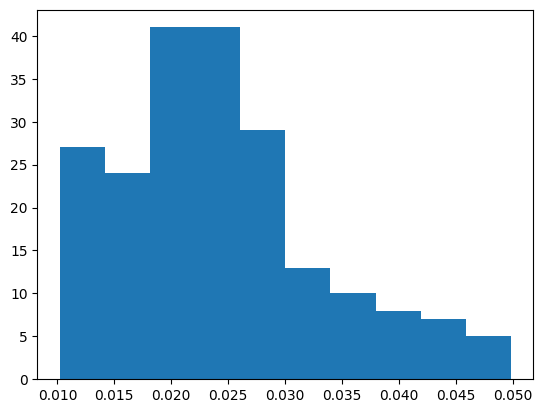

In [114]:
plt.hist(angle_list)
plt.show()

In [90]:
x_omma1 = np.random.uniform(xp[0],xp[-1])
y_omma1 = curve(x_omma1)
dp_dx = curve.deriv()

arc_length = 21.5385
x_omma2 = find_x2(arc_length, x_omma1)
y_omma2 = curve(x_omma1)
d1 = curve.deriv()(x_omma1)
d2 = curve.deriv()(x_omma2)

m1 = -1/d1
b1 = y_omma1 - m1 * x_omma1
m2 = -1/d2
b2 = y_omma2 - m2 * x_omma2

x_intersect = (b2 - b1) / (m1 - m2)
y_intersect = m1 * x_intersect + b1

angle = np.arctan(abs((m2 - m1) / (1 + m1 * m2)))

In [91]:
angle

4.436392894534693e-06

In [50]:
arc_length_temp, _ = quad(integrand, x_omma1, x_omma2)
arc_length_temp

21.550531017738148

In [64]:
curve

poly1d([-1.06182546e+00,  9.23921675e+03, -2.00962465e+07])